# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from glob import glob
import pandas as pd
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import time

from object_detection.utils import label_map_util

%matplotlib inline

# Model preparation object_detection

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [2]:
# What model to download.
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'object_detection/' + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Load a (frozen) Tensorflow model into memory.

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `3`, we know that this corresponds to `car`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [6]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
# PATH_TO_TEST_IMAGES_DIR = 'test_images'
#PATH_TO_IMAGES_DIR = 'inputs/test/'
#IMAGE_PATHS = glob(PATH_TO_IMAGES_DIR + '*.jpg')

df_train = pd.read_csv('inputs/valid_images_ex2.csv')
IMAGE_PATHS = df_train['img']

In [26]:
def set_coordinates(xmin, ymin, xmax, ymax, img_size):
    margin = 20
    im_width, im_height = img_size
    xmin = int(np.round(xmin*im_width))
    ymin = int(np.round(ymin*im_height))
    xmax = int(np.round(xmax*im_width))
    ymax = int(np.round(ymax*im_height))
    
    xmin = (xmin-margin) if(xmin-margin>0) else 0
    ymin = (ymin-margin) if(ymin-margin>0) else 0
    xmax = (xmax+margin) if(xmax+margin<im_width-1) else im_width-1
    ymax = (ymax+margin) if(ymax+margin<im_height-1) else im_height-1
    
    return xmin, ymin, xmax, ymax

In [27]:
num = 1
bboxes = []

In [28]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    start_time = time.time()
    for image_path in IMAGE_PATHS:
      image = Image.open(os.path.join('inputs/train/{}.jpg'.format(image_path)))
      #The array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      (ymin, xmin, ymax, xmax) = boxes[0][0]
      x1, y1, x2, y2 = set_coordinates(xmin, ymin, xmax, ymax, image.size)
      bboxes.append([image_path, x1, y1, x2, y2])
      if num%100==0:
        print '{0}/{1}--- {2} seconds ---'.format(num, len(IMAGE_PATHS), (time.time() - start_time))
        #np.savetxt('inputs/test_bbox_{0}.csv'.format(num), bboxes, fmt='%s', delimiter=',', newline='\n')
        start_time = time.time()
      num += 1
    
np.savetxt('inputs/valid_bboxes_ex2.csv', bboxes, fmt='%s', delimiter=',', newline='\n')

print 'Done'
    
      # Visualization of the results of a detection.
      #vis_util.visualize_boxes_and_labels_on_image_array(
      #    image_np,
      #    np.squeeze(boxes),
      #   np.squeeze(classes).astype(np.int32),
      #    np.squeeze(scores),
      
      #    category_index,
      
      #    use_normalized_coordinates=True,
      #    line_thickness=8)
      #plt.figure(figsize=IMAGE_SIZE)
      #plt.imshow(image_np)

100/1018--- 213.444602013 seconds ---
200/1018--- 210.722404957 seconds ---
300/1018--- 211.516982079 seconds ---
400/1018--- 210.411437035 seconds ---
500/1018--- 210.446332932 seconds ---
600/1018--- 210.175093174 seconds ---
700/1018--- 209.978820801 seconds ---
800/1018--- 210.809873104 seconds ---
900/1018--- 210.220891953 seconds ---
1000/1018--- 214.617166996 seconds ---
Done


## Visualization

In [29]:
import pandas as pd
from os import path
from matplotlib import pyplot as plt
from utilities import utils

%matplotlib inline

In [84]:
df_train = pd.read_csv('inputs/valid_images_ex2.csv')
IMAGE_PATHS = df_train['img']

bboxes = utils.get_bboxes('inputs/valid_bboxes_ex2_margin_30.csv')

917f262f1608_13 (1280, 1918, 3)
195 281 1714 863
195 281 1714 863


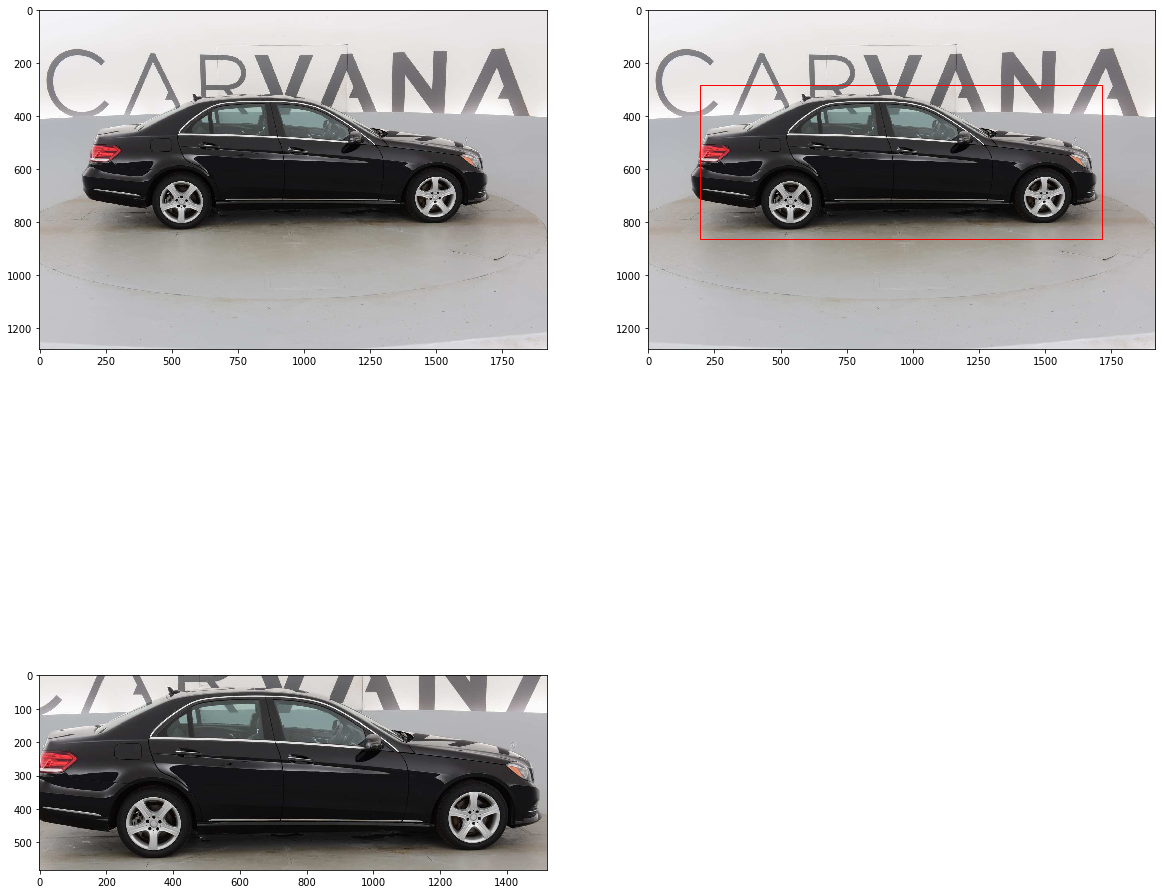

In [95]:
id_img=137

img = np.array(Image.open('inputs/train/{}.jpg'.format(IMAGE_PATHS[id_img])))
print IMAGE_PATHS[id_img], img.shape
xmin, ymin, xmax, ymax = bboxes[IMAGE_PATHS[id_img]]
print xmin, ymin, xmax, ymax
#xmin -=50
#xmax +=10
print xmin, ymin, xmax, ymax
cropped_img = img[ymin:ymax+1, xmin:xmax+1]

fig = plt.figure(figsize=(20, 20))
sub1 = fig.add_subplot(2, 2, 1)
sub1.imshow(img)
sub2 = fig.add_subplot(2, 2, 2)
sub2.add_patch(plt.Rectangle((xmin, ymin), width=xmax-xmin, height=ymax-ymin, fill=False, color='red')) 
sub2.imshow(img)
sub3 = fig.add_subplot(2, 2, 3)
sub3.imshow(cropped_img)